In [3]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [4]:
def build_preprocessor(num_cols, cat_cols):
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output= False))
    ])

    return ColumnTransformer([
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ])


In [5]:
def build_preprocessor_with_pca(num_cols, cat_cols, pca_variance=0.95):
    # Preprocesador original sin cambios
    preprocessor = build_preprocessor(num_cols, cat_cols)

    # Pipeline que aplica preprocesamiento + PCA
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=pca_variance, svd_solver='full'))
    ])

    return pipeline

In [6]:
def build_keras_model(input_shape, hidden_units=64, learning_rate=0.001, dropout_rate=0.3):
    model = models.Sequential([
        layers.InputLayer(shape=input_shape),
        layers.Dense(hidden_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', 'recall']
    )
    return model

In [8]:
df = pd.read_csv("data/dataset_practica_final.csv")
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [9]:
target_col = 'is_canceled'
X = df.drop(columns=['is_canceled', 'reservation_status', 'reservation_status_date'])
y = df[target_col]

#Ingeniería de columnas para eliminar columnas altamente correlacionadas
X['arrival_time_index'] = X['arrival_date_year'] + (X['arrival_date_week_number'] / 52)
X = X.drop(columns=['arrival_date_year', 'arrival_date_week_number'])


num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

num_imputer = SimpleImputer(strategy='constant', fill_value=0)
cat_imputer = SimpleImputer(strategy='most_frequent')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

preprocessor = build_preprocessor(num_cols, cat_cols)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [10]:
sklearn_models = {
    'LogisticRegression': (LogisticRegression(max_iter=1000), {
        'C': [0.1, 1, 10]
    }),
    'DecisionTree': (DecisionTreeClassifier(), {
        'max_depth': [5, 10, 20]
    }),
    'RandomForest': (RandomForestClassifier(), {
        'n_estimators': [50, 100],
        'max_depth': [10, 20]
    }),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
        'n_estimators': [50, 100],
        'max_depth': [3, 6]
    })
}

In [11]:
preprocessor = build_preprocessor(num_cols, cat_cols)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

results = []
sklearn_results = {}

for name, (model, param_grid) in sklearn_models.items():
    print(f"\nSearching best params for: {name}")

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='recall',  # criterio de selección
        cv=3,
        n_jobs=-1
    )
    grid.fit(X_train_processed, y_train)

    # Guardamos el modelo completo
    sklearn_results[name] = grid

    # Predecimos en el test set
    y_pred = grid.predict(X_test_processed)
    y_prob = grid.predict_proba(X_test_processed)[:, 1] if hasattr(grid, 'predict_proba') else None

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    # Guardamos los resultados en una lista
    results.append({
        'model': name,
        'best_params': grid.best_params_,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'roc_auc': auc
    })

    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Test metrics - Acc: {acc:.4f}, Prec: {prec:.4f}, Recall: {rec:.4f}, AUC: {auc:.4f}")


Searching best params for: LogisticRegression
Best params for LogisticRegression: {'C': 10}
Test metrics - Acc: 0.8198, Prec: 0.8135, Recall: 0.6661, AUC: 0.8963

Searching best params for: DecisionTree
Best params for DecisionTree: {'max_depth': 20}
Test metrics - Acc: 0.8697, Prec: 0.8274, Recall: 0.8190, AUC: 0.9166

Searching best params for: RandomForest
Best params for RandomForest: {'max_depth': 20, 'n_estimators': 100}
Test metrics - Acc: 0.8727, Prec: 0.9085, Recall: 0.7298, AUC: 0.9501

Searching best params for: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params for XGBoost: {'max_depth': 6, 'n_estimators': 100}
Test metrics - Acc: 0.8815, Prec: 0.8631, Recall: 0.8083, AUC: 0.9536


In [12]:
results_df = pd.DataFrame(results)
results_df.sort_values(by='recall', ascending=False)

,model,best_params,accuracy,precision,recall,roc_auc
1,DecisionTree,{'max_depth': 20},0.869671,0.827413,0.818994,0.916615
3,XGBoost,"{'max_depth': 6, 'n_estimators': 100}",0.881481,0.863093,0.808253,0.953614
2,RandomForest,"{'max_depth': 20, 'n_estimators': 100}",0.872686,0.908515,0.729791,0.950149
0,LogisticRegression,{'C': 10},0.819750,0.813475,0.666139,0.896343


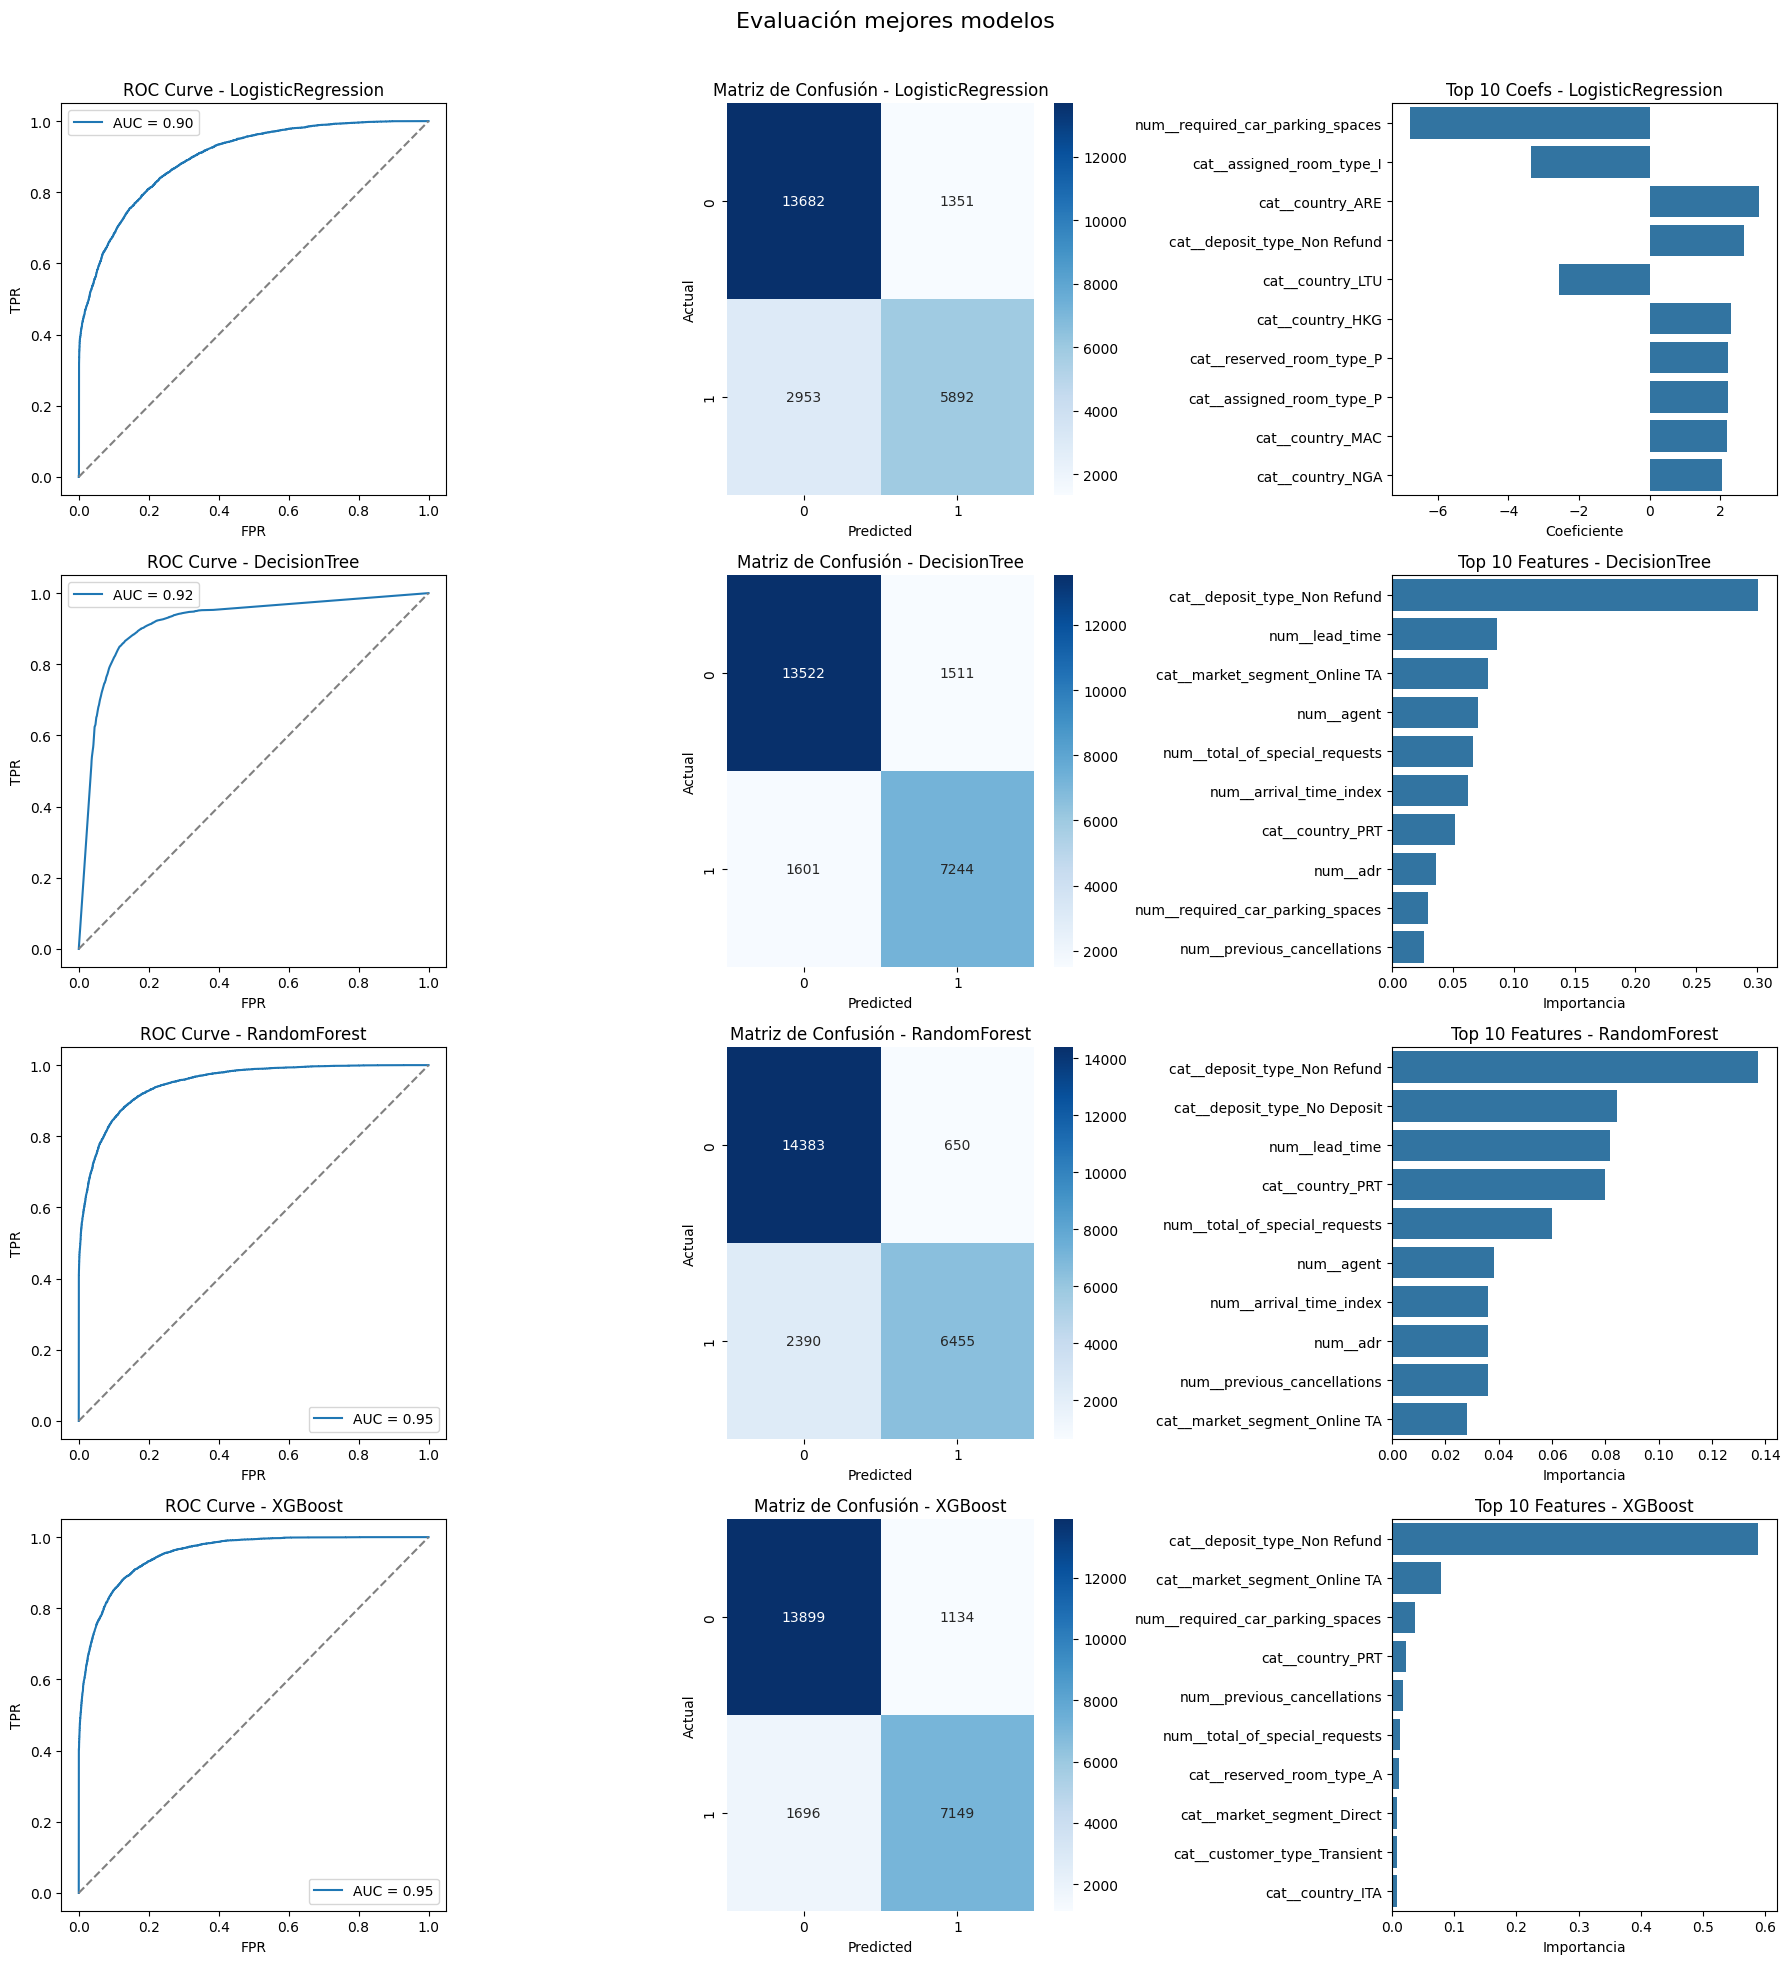

In [13]:
feature_names = preprocessor.get_feature_names_out()

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 20))
fig.suptitle('Evaluación mejores modelos', fontsize=16)

for i, (name, grid) in enumerate(sklearn_results.items()):
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_processed)
    y_prob = best_model.predict_proba(X_test_processed)[:, 1] if hasattr(best_model, 'predict_proba') else None

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        axes[i, 0].plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.2f}')
        axes[i, 0].plot([0, 1], [0, 1], linestyle='--', color='gray')
        axes[i, 0].set_title(f'ROC Curve - {name}')
        axes[i, 0].set_xlabel('FPR')
        axes[i, 0].set_ylabel('TPR')
        axes[i, 0].legend()
    else:
        axes[i, 0].text(0.5, 0.5, 'No probabilidad', ha='center', va='center')
        axes[i, 0].set_title(f'ROC Curve - {name}')
        axes[i, 0].axis('off')

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i, 1])
    axes[i, 1].set_title(f'Matriz de Confusión - {name}')
    axes[i, 1].set_xlabel('Predicted')
    axes[i, 1].set_ylabel('Actual')

    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        top_indices = np.argsort(importances)[-10:][::-1]
        top_features = [feature_names[i] for i in top_indices]
        sns.barplot(x=importances[top_indices], y=top_features, ax=axes[i, 2], orient='h')
        axes[i, 2].set_title(f'Top 10 Features - {name}')
        axes[i, 2].set_xlabel('Importancia')
    elif hasattr(best_model, 'coef_'):  # para regresión logística
        coefs = best_model.coef_[0]
        top_indices = np.argsort(np.abs(coefs))[-10:][::-1]
        top_features = [feature_names[i] for i in top_indices]
        sns.barplot(x=coefs[top_indices], y=top_features, ax=axes[i, 2], orient='h')
        axes[i, 2].set_title(f'Top 10 Coefs - {name}')
        axes[i, 2].set_xlabel('Coeficiente')
    else:
        axes[i, 2].text(0.5, 0.5, 'No disponible', ha='center', va='center')
        axes[i, 2].set_title(f'Top 10 Features - {name}')
        axes[i, 2].axis('off')

# Ajustar diseño
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [23]:
results_dict = {}
results_pca = []

preprocessor_pca = build_preprocessor_with_pca(num_cols, cat_cols, pca_variance=0.95)
X_train_processed = preprocessor_pca.fit_transform(X_train)
X_test_processed = preprocessor_pca.transform(X_test)


for name, (model, param_grid) in sklearn_models.items():
    print(f"\nSearching best params for: {name}")

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='recall',
        cv=3,
        n_jobs=-1
    )
    grid.fit(X_train_processed, y_train)
    results[name] = grid

     # Predecimos en el test set
    y_pred = grid.predict(X_test_processed)
    y_prob = grid.predict_proba(X_test_processed)[:, 1] if hasattr(grid, 'predict_proba') else None

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    # Guardamos los resultados en una lista
    results_pca.append({
        'model': name,
        'best_params': grid.best_params_,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'roc_auc': auc
    })

    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Best recall: {grid.best_score_:.4f}")



Searching best params for: LogisticRegression
Best params for LogisticRegression: {'C': 10}
Best recall: 0.6444

Searching best params for: DecisionTree
Best params for DecisionTree: {'max_depth': 20}
Best recall: 0.7530

Searching best params for: RandomForest
Best params for RandomForest: {'max_depth': 20, 'n_estimators': 50}
Best recall: 0.7465

Searching best params for: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:59:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params for XGBoost: {'max_depth': 6, 'n_estimators': 100}
Best recall: 0.7625


In [32]:
results_pca_df = pd.DataFrame(results_pca)
results_pca_df.sort_values(by='recall', ascending=False)

,model,best_params,accuracy,precision,recall,roc_auc
1,DecisionTree,{'max_depth': 20},0.827205,0.771425,0.758168,0.824373
3,XGBoost,"{'max_depth': 6, 'n_estimators': 100}",0.863389,0.856832,0.757829,0.937596
2,RandomForest,"{'max_depth': 20, 'n_estimators': 50}",0.872770,0.884824,0.754777,0.943027
0,LogisticRegression,{'C': 10},0.807731,0.801275,0.639570,0.881089


In [14]:
keras_params = {
    'learning_rate': [0.001, 0.01],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [32],
    'epochs': [10]
}

best_score = 0
best_model = None
best_params = {}

for lr in keras_params['learning_rate']:
    for dr in keras_params['dropout_rate']:
        print(f"Training model with lr={lr}, dr={dr}")
        model = build_keras_model(
            input_shape=(X_train_processed.shape[1],),
            learning_rate=lr,
            dropout_rate=dr
        )

        history = model.fit(
            X_train_processed, y_train,
            batch_size=32,
            epochs=10,
            validation_split=0.2,
            verbose=0,
            callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
        )

        # Evaluate based on max validation recall
        val_recall = max(history.history['val_recall'])
        if val_recall > best_score:
            best_score = val_recall
            best_model = model
            best_params = {'lr': lr, 'dropout_rate': dr}

print("\nEvaluating best Keras model on test set...")

y_pred_prob = best_model.predict(X_test_processed).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

results.append({
    'model': 'Keras',
    'best_params': best_params,
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'roc_auc': auc
})

print(f"Keras best params: {best_params}")
print(f"Keras Test metrics - Acc: {acc:.4f}, Prec: {prec:.4f}, Recall: {rec:.4f}, AUC: {auc:.4f}")


Training model with lr=0.001, dr=0.2
Training model with lr=0.001, dr=0.3
Training model with lr=0.01, dr=0.2
Training model with lr=0.01, dr=0.3

Evaluating best Keras model on test set...
747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Keras best params: {'lr': 0.01, 'dropout_rate': 0.2}
Keras Test metrics - Acc: 0.8615, Prec: 0.8766, Recall: 0.7287, AUC: 0.9405


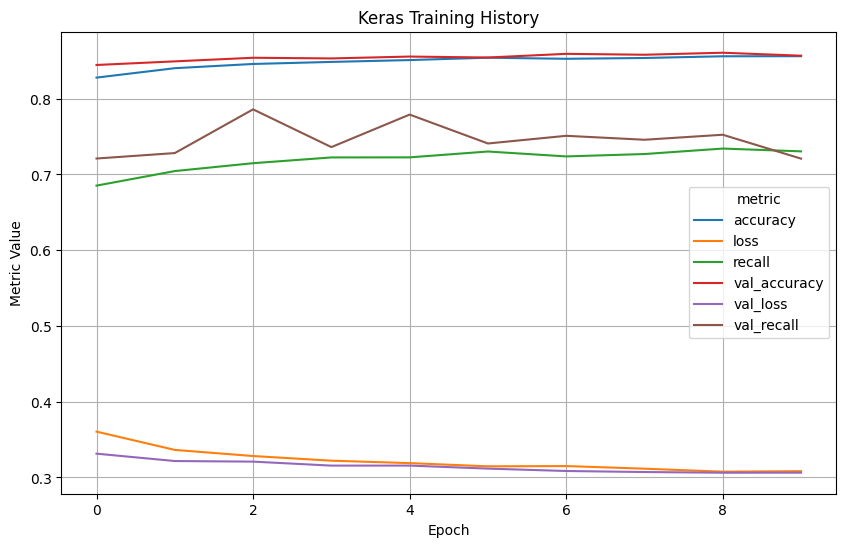

In [15]:
df_hist = pd.DataFrame(history.history)
df_hist['epoch'] = history.epoch

df_long = df_hist.melt(id_vars='epoch', value_name='value', var_name='metric')

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x='epoch', y='value', hue='metric')
plt.title("Keras Training History")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.grid(True)
plt.show()

In [18]:
results_df = pd.DataFrame(results)
results_df

,model,best_params,accuracy,precision,recall,roc_auc
0,LogisticRegression,{'C': 10},0.819750,0.813475,0.666139,0.896343
1,DecisionTree,{'max_depth': 20},0.868289,0.825046,0.817863,0.915132
2,RandomForest,"{'max_depth': 20, 'n_estimators': 50}",0.872309,0.903734,0.733409,0.948831
3,XGBoost,"{'max_depth': 6, 'n_estimators': 100}",0.881481,0.863093,0.808253,0.953614
4,Keras,"{'lr': 0.01, 'dropout_rate': 0.2}",0.864185,0.857453,0.759638,0.939540


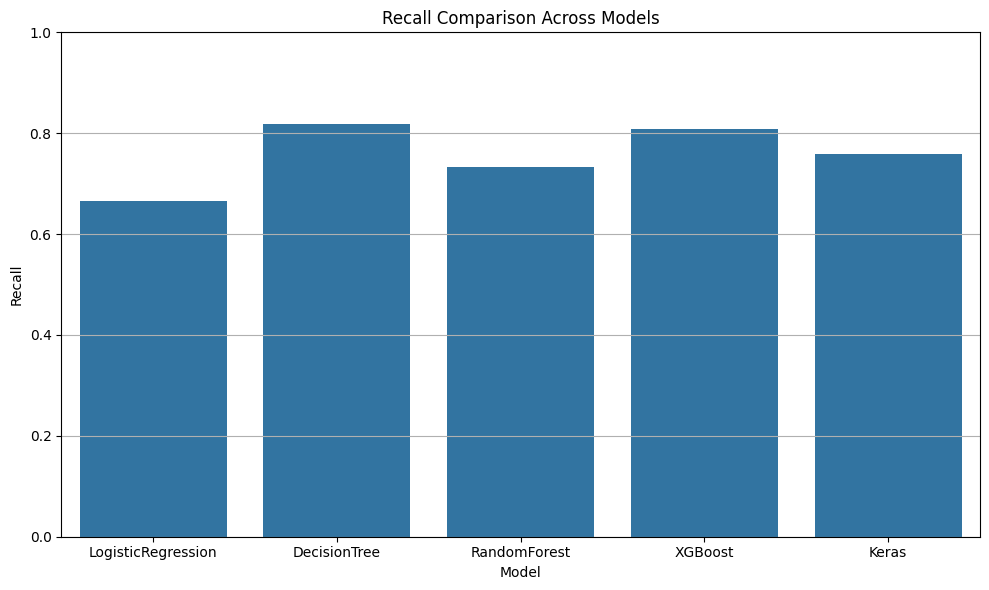

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='model', y='recall')
plt.title('Recall Comparison Across Models')
plt.ylabel('Recall')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()